In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2

### Some utility functions

In [4]:
def plot_M_grid(M_grid, px_list, pz_list, log=False, log_scale = 1e-4):
    plt.figure(facecolor='white', figsize=(12,6))

    M2_grid = np.abs(M_grid)**2
    MMax = np.max(M2_grid)

    if log:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', norm=LogNorm(vmin=MMax*log_scale, vmax=MMax),
                   interpolation = 'bicubic', aspect = 1.)
    else:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', interpolation = 'bicubic', aspect = 1.)

    plt.ylabel("$p_x$")
    plt.xlabel("$p_z$")
    plt.colorbar()
    plt.show()

def hyd1s(r, theta, phi):
    return 1/np.sqrt(np.pi) * np.exp(-r)

### Load the GAMESS GTO expansion of ground state hydrogen for testing!

In [5]:
file_name = 'output_files/Hydrogen.out'
output = OutputInterface(file_name)
Ip = -output.saved_orbitals[output.HOMO][0]  # Should we put this to 1/2?
kappa = np.sqrt(2*Ip)
GTO_coeffs = np.array(output.output_GTOs())

#### Fit to the asymptotic form

N should be an even number! Incrementing by one


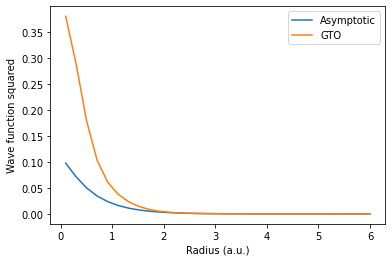

In [6]:
clm_array_GTO = se.get_as_coeffs(output.eval_orbital_spherical, 2.5, 15, Ip)

phi = 0
theta = 0

n_r = 30
r_lst = np.linspace(0.1, 6, n_r)

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array_GTO, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
#plt.plot(r_lst, np.abs(hyd_1s(r_lst, 0., 0.))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

#### Asymptotic form matched directly to the 1s state of hydrogen

N should be an even number! Incrementing by one


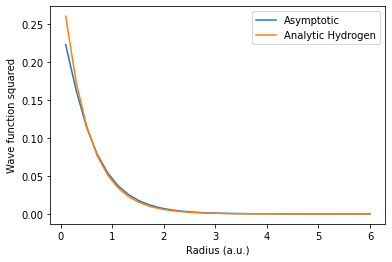

In [7]:
clm_array_analytic = se.get_as_coeffs(hyd1s, 2.5, 15, 0.5)

phi = 0
theta = 0

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array_analytic, Ip))**2, label='Asymptotic')
#plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
plt.plot(r_lst, np.abs(hyd1s(r_lst, 0., 0.))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

## Time to calculate with different prefactors!

In [11]:
N = 50
pz_list = np.linspace(-1.5, 1.5, 2*N)
px_list = np.linspace(0, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

### Analytical expression for ground state hydrogen with numerical integration:

In [12]:
SP_1s_num  = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="hyd1s_analytic")
M_1s_num = np.array(pool.starmap(SP_1s_num.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid)))

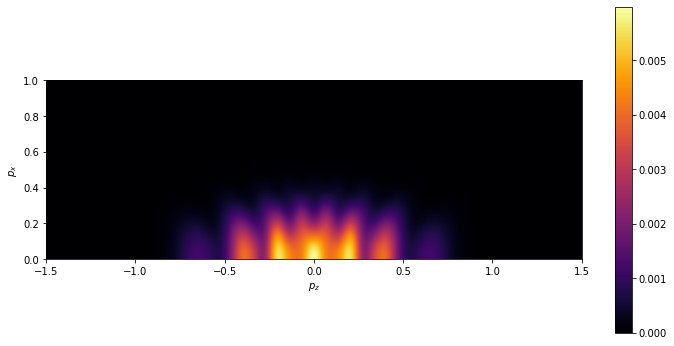

In [13]:
plot_M_grid(M_1s_num, px_list, pz_list)

### With GAMESS GTO expansion in SPA

In [14]:
SP_GTO = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO = np.array(pool.starmap(SP_GTO.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(GTO_coeffs))))

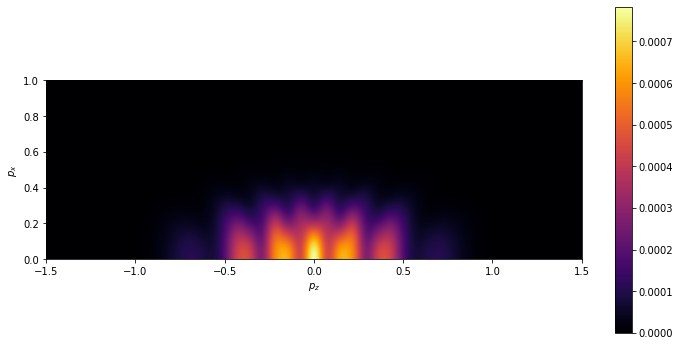

In [15]:
plot_M_grid(M_GTO, px_list, pz_list)

### With GTO numerically

In [16]:
M_GTO_num = np.array(pool.starmap(SP_GTO.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid, repeat(GTO_coeffs))))

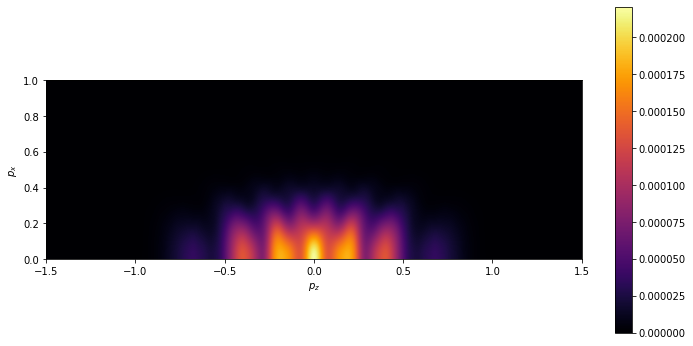

In [17]:
plot_M_grid(M_GTO_num, px_list, pz_list)

### Shifted hydrogen away from origin - GTO, SPA

In [18]:
x0, y0, z0 = (0, 0, 2)  # Shift of hydrogen atom
shift_GTO_coeffs = GTO_coeffs.copy()
shift_GTO_coeffs[:,-3] = x0
shift_GTO_coeffs[:,-2] = y0
shift_GTO_coeffs[:,-1] = z0

In [19]:
SP_GTO_shift = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO_shift = np.array(pool.starmap(SP_GTO_shift.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(shift_GTO_coeffs))))

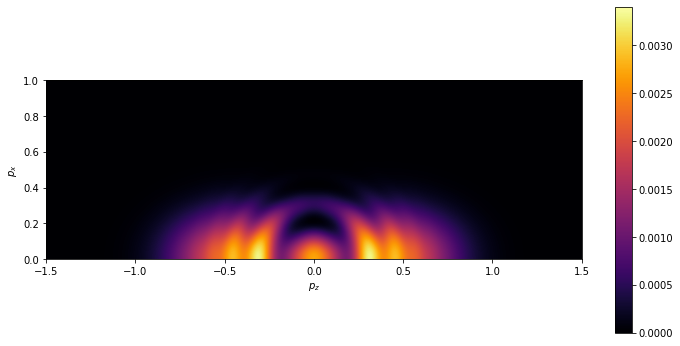

In [20]:
plot_M_grid(M_GTO_shift, px_list, pz_list)

### Same as above, but numerically

In [21]:
SP_GTO_shift_num = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="GTO")
M_GTO_shift_num = np.array(pool.starmap(SP_GTO_shift.Mxz_List_num, zip(pxGrid, repeat(py), pzGrid, repeat(shift_GTO_coeffs))))

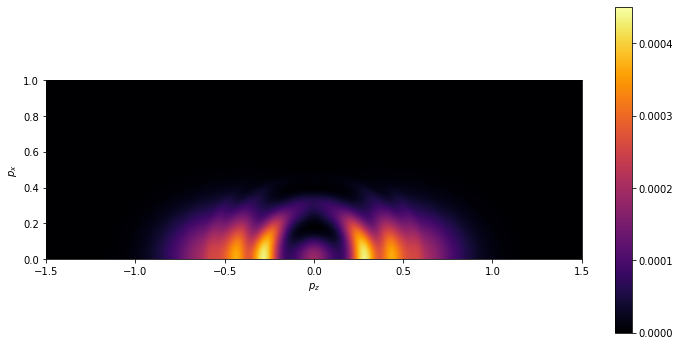

In [22]:
plot_M_grid(M_GTO_shift_num, px_list, pz_list)

### With Martiny's asymptotic version

#### First using the expansion of the GTO WF

In [29]:
SP_asymp_martiny = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")
M_asymp_martiny = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_GTO))))

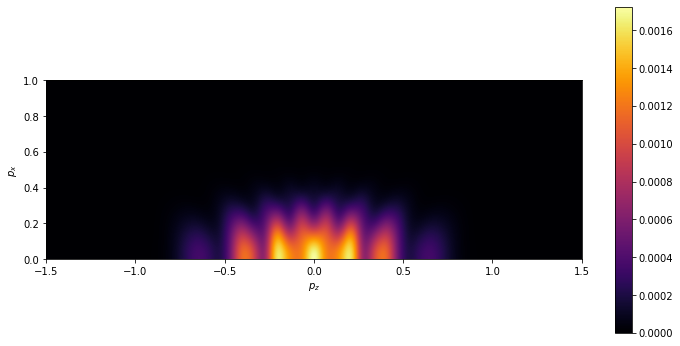

In [30]:
plot_M_grid(M_asymp_martiny, px_list, pz_list)

#### And then using the expansion of the analytical WF

In [27]:
M_asymp_martiny = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_analytic))))

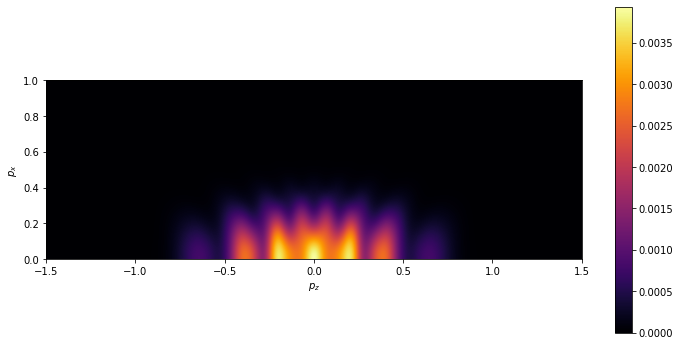

In [28]:
plot_M_grid(M_asymp_martiny, px_list, pz_list)